In [1]:
import collections
from pathlib import Path
import sys
import time

import numpy as np
import cv2
from IPython import display
import matplotlib.pyplot as plt
import openvino as ov

In [2]:
# Import local modules

utils_file_path = Path('../utils/notebook_utils.py')
notebook_directory_path = Path('.')

if not utils_file_path.exists():
    !git clone --depth 1 https://github.com/igor-davidyuk/openvino_notebooks.git -b moving_data_to_cloud openvino_notebooks
    utils_file_path = Path('./openvino_notebooks/notebooks/utils/notebook_utils.py')
    notebook_directory_path = Path('./openvino_notebooks/notebooks/407-person-tracking-webcam/')

sys.path.append(str(utils_file_path.parent))
sys.path.append(str(notebook_directory_path))

import notebook_utils as utils
from deepsort_utils.tracker import Tracker
from deepsort_utils.nn_matching import NearestNeighborDistanceMetric
from deepsort_utils.detection import Detection, compute_color_for_labels, xywh_to_xyxy, xywh_to_tlwh, tlwh_to_xyxy

Cloning into 'openvino_notebooks'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (389/389), done.
remote: Total 421 (delta 26), reused 271 (delta 14), pack-reused 0
Receiving objects: 100% (421/421), 55.50 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [3]:
# A directory where the model will be downloaded.
base_model_dir = "model"
precision = "FP16"
# The name of the model from Open Model Zoo
detection_model_name = "person-detection-0202"

download_command = f"omz_downloader " \
                   f"--name {detection_model_name} " \
                   f"--precisions {precision} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

detection_model_path = f"model/intel/{detection_model_name}/{precision}/{detection_model_name}.xml"


reidentification_model_name = "person-reidentification-retail-0287"

download_command = f"omz_downloader " \
                   f"--name {reidentification_model_name} " \
                   f"--precisions {precision} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

reidentification_model_path = f"model/intel/{reidentification_model_name}/{precision}/{reidentification_model_name}.xml"

################|| Downloading person-detection-0202 ||################

========== Downloading model/intel/person-detection-0202/FP16/person-detection-0202.xml
... 100%, 248 KB, 269 KB/s, 0 seconds passed

========== Downloading model/intel/person-detection-0202/FP16/person-detection-0202.bin
... 100%, 3549 KB, 1962 KB/s, 1 seconds passed

################|| Downloading person-reidentification-retail-0287 ||################

========== Downloading model/intel/person-reidentification-retail-0287/person-reidentification-retail-0267.onnx
... 100%, 3487 KB, 408 KB/s, 8 seconds passed

========== Downloading model/intel/person-reidentification-retail-0287/FP16/person-reidentification-retail-0287.xml
... 100%, 600 KB, 508 KB/s, 1 seconds passed

========== Downloading model/intel/person-reidentification-retail-0287/FP16/person-reidentification-retail-0287.bin
... 100%, 1153 KB, 891 KB/s, 1 seconds passed



In [4]:
core = ov.Core()


class Model:
    """
    This class represents a OpenVINO model object.

    """
    def __init__(self, model_path, batchsize=1, device="AUTO"):
        """
        Initialize the model object

        Parameters
        ----------
        model_path: path of inference model
        batchsize: batch size of input data
        device: device used to run inference
        """
        self.model = core.read_model(model=model_path)
        self.input_layer = self.model.input(0)
        self.input_shape = self.input_layer.shape
        self.height = self.input_shape[2]
        self.width = self.input_shape[3]

        for layer in self.model.inputs:
            input_shape = layer.partial_shape
            input_shape[0] = batchsize
            self.model.reshape({layer: input_shape})
        self.compiled_model = core.compile_model(model=self.model, device_name=device)
        self.output_layer = self.compiled_model.output(0)

    def predict(self, input):
        """
        Run inference

        Parameters
        ----------
        input: array of input data
        """
        result = self.compiled_model(input)[self.output_layer]
        return result

In [5]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [6]:
detector = Model(detection_model_path, device=device.value)
# since the number of detection object is uncertain, the input batch size of reid model should be dynamic
extractor = Model(reidentification_model_path, -1, device.value)

In [7]:
def preprocess(frame, height, width):
    """
    Preprocess a single image

    Parameters
    ----------
    frame: input frame
    height: height of model input data
    width: width of model input data
    """
    resized_image = cv2.resize(frame, (width, height))
    resized_image = resized_image.transpose((2, 0, 1))
    input_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
    return input_image


def batch_preprocess(img_crops, height, width):
    """
    Preprocess batched images

    Parameters
    ----------
    img_crops: batched input images
    height: height of model input data
    width: width of model input data
    """
    img_batch = np.concatenate([
        preprocess(img, height, width)
        for img in img_crops
    ], axis=0)
    return img_batch


def process_results(h, w, results, thresh=0.5):
    """
    postprocess detection results

    Parameters
    ----------
    h, w: original height and width of input image
    results: raw detection network output
    thresh: threshold for low confidence filtering
    """
    # The 'results' variable is a [1, 1, N, 7] tensor.
    detections = results.reshape(-1, 7)
    boxes = []
    labels = []
    scores = []
    for i, detection in enumerate(detections):
        _, label, score, xmin, ymin, xmax, ymax = detection
        # Filter detected objects.
        if score > thresh:
            # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
            boxes.append(
                [(xmin + xmax) / 2 * w, (ymin + ymax) / 2 * h, (xmax - xmin) * w, (ymax - ymin) * h]
            )
            labels.append(int(label))
            scores.append(float(score))

    if len(boxes) == 0:
        boxes = np.array([]).reshape(0, 4)
        scores = np.array([])
        labels = np.array([])
    return np.array(boxes), np.array(scores), np.array(labels)


def draw_boxes(img, bbox, identities=None):
    """
    Draw bounding box in original image

    Parameters
    ----------
    img: original image
    bbox: coordinate of bounding box
    identities: identities IDs
    """
    for i, box in enumerate(bbox):
        x1, y1, x2, y2 = [int(i) for i in box]
        # box text and bar
        id = int(identities[i]) if identities is not None else 0
        color = compute_color_for_labels(id)
        label = '{}{:d}'.format("", id)
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.rectangle(
            img, (x1, y1), (x1 + t_size[0] + 3, y1 + t_size[1] + 4), color, -1)
        cv2.putText(
            img,
            label,
            (x1, y1 + t_size[1] + 4),
            cv2.FONT_HERSHEY_PLAIN,
            1.6,
            [255, 255, 255],
            2
        )
    return img


def cosin_metric(x1, x2):
    """
    Calculate the consin distance of two vector

    Parameters
    ----------
    x1, x2: input vectors
    """
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

data/person_1_1.png:   0%|          | 0.00/68.3k [00:00<?, ?B/s]

data/person_1_2.png:   0%|          | 0.00/68.9k [00:00<?, ?B/s]

data/person_2_1.png:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

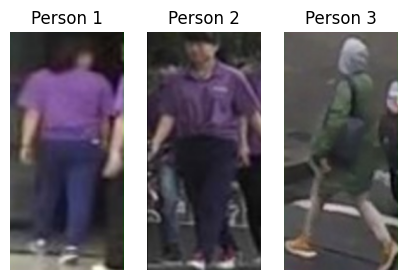

In [8]:
base_file_link = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/person_'
image_indices = ['1_1.png', '1_2.png', '2_1.png']
image_paths = [utils.download_file(base_file_link + image_index, directory='data') for image_index in image_indices]
image1, image2, image3 = [cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB) for image_path in image_paths]

# Define titles with images.
data = {"Person 1": image1, "Person 2": image2, "Person 3": image3}

# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(5, 5))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)

In [9]:
# Metric parameters
MAX_COSINE_DISTANCE = 0.6  # threshold of matching object
input_data = [image2, image3]
img_batch = batch_preprocess(input_data, extractor.height, extractor.width)
features = extractor.predict(img_batch)
sim = cosin_metric(features[0], features[1])
if sim >= 1 - MAX_COSINE_DISTANCE:
    print(f'Same person (confidence: {sim})')
else:
    print(f'Different person (confidence: {sim})')

Different person (confidence: 0.027266180142760277)


In [13]:
# Main processing function to run person tracking.
def run_person_tracking(source=0, flip=False, use_popup=False, skip_first_frames=0, save_video=True, output_path='ref_vid_detected.avi'):
    """
    Main function to run the person tracking:
    1. Create a video player to play with target fps (utils.VideoPlayer).
    2. Prepare a set of frames for person tracking.
    3. Run AI inference for person tracking.
    4. Visualize the results.

    Parameters:
    ----------
        source: The webcam number to feed the video stream with primary webcam set to "0", or the video path.
        flip: To be used by VideoPlayer function for flipping capture image.
        use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
        skip_first_frames: Number of frames to skip at the beginning of the video.
    """
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, size=(700, 450), flip=flip, fps=24, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()

        if save_video:
            # Define the codec and create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            video_writer = cv2.VideoWriter(output_path, fourcc, 24.0, (700, 450))
        
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.

            # Resize the image and change dims to fit neural network input.
            h, w = frame.shape[:2]
            input_image = preprocess(frame, detector.height, detector.width)

            # Measure processing time.
            start_time = time.time()
            # Get the results.
            output = detector.predict(input_image)
            stop_time = time.time()
            processing_times.append(stop_time - start_time)
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1100
            fps = 1000 / processing_time

            # Get poses from detection results.
            bbox_xywh, score, label = process_results(h, w, results=output)

            img_crops = []
            for box in bbox_xywh:
                x1, y1, x2, y2 = xywh_to_xyxy(box, h, w)
                img = frame[y1:y2, x1:x2]
                img_crops.append(img)

            # Get reidentification feature of each person.
            if img_crops:
                # preprocess
                img_batch = batch_preprocess(img_crops, extractor.height, extractor.width)
                features = extractor.predict(img_batch)
            else:
                features = np.array([])

            # Wrap the detection and reidentification results together
            bbox_tlwh = xywh_to_tlwh(bbox_xywh)
            detections = [
                Detection(bbox_tlwh[i], features[i])
                for i in range(features.shape[0])
            ]

            # predict the position of tracking target
            tracker.predict()

            # update tracker
            tracker.update(detections)

            # update bbox identities
            outputs = []
            for track in tracker.tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue
                box = track.to_tlwh()
                x1, y1, x2, y2 = tlwh_to_xyxy(box, h, w)
                track_id = track.track_id
                outputs.append(np.array([x1, y1, x2, y2, track_id], dtype=np.int32))
            if len(outputs) > 0:
                outputs = np.stack(outputs, axis=0)

            # draw box for visualization
            if len(outputs) > 0:
                bbox_tlwh = []
                bbox_xyxy = outputs[:, :4]
                identities = outputs[:, -1]
                frame = draw_boxes(frame, bbox_xyxy, identities)

            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)


            if save_video:
                video_writer.write(frame)

    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

In [14]:
NN_BUDGET = 100
MAX_COSINE_DISTANCE = 0.6  # threshold of matching object
metric = NearestNeighborDistanceMetric(
    "cosine", MAX_COSINE_DISTANCE, NN_BUDGET
)
tracker = Tracker(
    metric,
    max_iou_distance=0.7,
    max_age=70,
    n_init=3
)

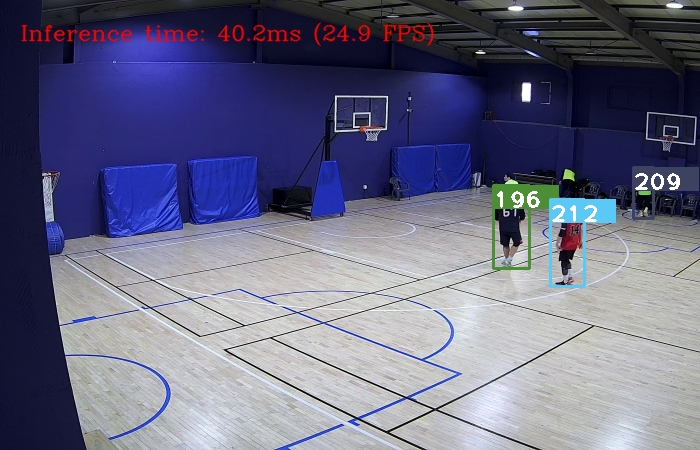

Source ended


In [15]:
USE_WEBCAM = False

cam_id = 0
video_file = 'ref_vid.mp4'
source = cam_id if USE_WEBCAM else video_file

run_person_tracking(source=source, flip=USE_WEBCAM, use_popup=False)

# save the